<a href="https://colab.research.google.com/github/bikash119/learn_tensorflow/blob/main/learn_tf_004.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Convolutional Neural Networks and Computer Vision with TensorFlow
This notebook will cover the following with TensorFlow:
* Getting a dataset to work with.
* Architecture of convolutional neural network
* A quick end-to-end example
* Steps in modelling for binary image classifications with CNNs
  * Becoming one with data
  * Preparing the data for modelling.
  * Creating a CNN model ( starting with baseline )
  * Evaluating a model
  * Improving a model
  * Making a prediction with trained model
* Steps in modelling for multi-class image classification with CNNs
  * Same as above but with a multi-class dataset



## Get the data
The images we will be using are from the [Food-101 dataset](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/), a collection of 101 different categories of 101,000 real world images of food dishes.

In [1]:
import zipfile
# Downlad the zip file of pizza_steak images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip

#unzip the zip file
zip_ref = zipfile.ZipFile('pizza_steak.zip','r')
zip_ref.extractall()
zip_ref.close()

--2023-07-08 03:02:17--  https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.79.128, 108.177.119.128, 108.177.126.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.79.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 109540975 (104M) [application/zip]
Saving to: ‘pizza_steak.zip.1’

pizza_steak.zip.1   100%[===================>] 104.47M  31.6MB/s    in 3.7s    

2023-07-08 03:02:21 (28.6 MB/s) - ‘pizza_steak.zip.1’ saved [109540975/109540975]



Inspect the data [Becoming one with data](https://karpathy.github.io/2019/04/25/recipe/)

In [2]:
# File structure
!ls pizza_steak

test  train


In [3]:
!pip install tree

In [4]:
import os
for dirpath, dirnames,filenames in os.walk("pizza_steak"):
  print(f" There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")

 There are 2 directories and 0 images in pizza_steak
 There are 2 directories and 0 images in pizza_steak/train
 There are 0 directories and 750 images in pizza_steak/train/pizza
 There are 0 directories and 750 images in pizza_steak/train/steak
 There are 2 directories and 0 images in pizza_steak/test
 There are 0 directories and 250 images in pizza_steak/test/pizza
 There are 0 directories and 250 images in pizza_steak/test/steak


In [5]:
# Get the class names
## the class names are the name of the folders containing respective images.

import pathlib
import numpy as np

def get_classnames(train_dir: str) -> list[str]:

  """
    This function will return the name of the folers in training directory.
    Args:
      train_dir(str): The name of train directory

    Returns:
      directory_names(list[str]): The name of the directories in the train_dir directory.
  """
  data_dir = pathlib.Path(train_dir)
  folder_names = sorted([item.name for item in data_dir.glob("*")])
  return folder_names


In [6]:
classnames = get_classnames("pizza_steak/train")
classnames

['pizza', 'steak']

> 🔑note: Whenever working with data, it's always good to visualize as much as possible. The first few steps of any project is becoming one with data. **Visualize**, **visualize**, **visualize**

Let's write a function to plot a random image and its shape

In [7]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

# function to view a random image from given a target directory and a target class

def view_random_image(target_dir,target_class):
  target_folder = target_dir + target_class

  # Get a random image path
  random_image = random.sample(os.listdir(target_folder),1)
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  print(f" Showing image {random_image[0]} from {target_folder}")
  print(f" Shape of the image {img.shape}")
  plt.title(target_class)
  plt.axis("off")
  return img

 Showing image 382829.jpg from pizza_steak/train/pizza
 Shape of the image (384, 512, 3)


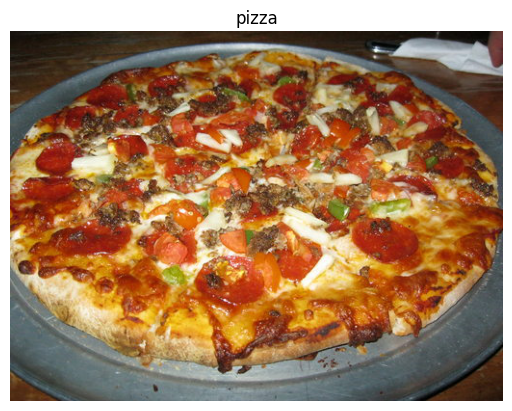

In [8]:
img = view_random_image("pizza_steak/train/","pizza")

In [9]:
img.max(),img.min()

(255, 0)

In [10]:
img/255

array([[[0.09803922, 0.07843137, 0.0627451 ],
        [0.10196078, 0.08235294, 0.06666667],
        [0.10196078, 0.08235294, 0.06666667],
        ...,
        [0.40392157, 0.23529412, 0.21176471],
        [0.40784314, 0.23137255, 0.21176471],
        [0.41568627, 0.22745098, 0.21176471]],

       [[0.08627451, 0.06666667, 0.05098039],
        [0.09019608, 0.07058824, 0.05490196],
        [0.09411765, 0.0745098 , 0.05882353],
        ...,
        [0.39607843, 0.22745098, 0.20392157],
        [0.39607843, 0.21960784, 0.2       ],
        [0.40392157, 0.21568627, 0.2       ]],

       [[0.08235294, 0.0627451 , 0.04705882],
        [0.08627451, 0.06666667, 0.05098039],
        [0.09019608, 0.07058824, 0.05490196],
        ...,
        [0.4       , 0.22352941, 0.20392157],
        [0.40392157, 0.21568627, 0.20784314],
        [0.4       , 0.21176471, 0.20392157]],

       ...,

       [[0.30196078, 0.16078431, 0.06666667],
        [0.30588235, 0.16470588, 0.07058824],
        [0.30980392, 0

# An end-to-end example

In [11]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# set seed
tf.random.set_seed(42)

# Preprocess data ( get all the pixel values of a image within 0,1)
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

# Set up the train and test directories
train_dir = "pizza_steak/train"
test_dir = "pizza_steak/test"

# import data from directories and turn them into batches
train_data = train_datagen.flow_from_directory(train_dir
                                               ,batch_size=32
                                               ,target_size=(224,224)
                                               ,class_mode="binary"
                                               ,seed=42)
valid_data = valid_datagen.flow_from_directory(test_dir
                                               ,batch_size=32
                                               ,target_size=(224,224)
                                               ,class_mode="binary"
                                               ,seed=42)

# Create an CNN (TinyVGG) model same as https://poloclub.github.io/cnn-explainer/

model_1 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=10
                           ,kernel_size=(3,3)
                           ,activation="relu"
                           ,input_shape=(224,224,3))
    ,tf.keras.layers.Conv2D(10,3,activation="relu")
    ,tf.keras.layers.MaxPool2D(pool_size=2
                               ,padding="valid")
    ,tf.keras.layers.Conv2D(10,3,activation="relu")
    ,tf.keras.layers.Conv2D(10,3,activation="relu")
    ,tf.keras.layers.MaxPool2D(2)
    ,tf.keras.layers.Flatten()
    ,tf.keras.layers.Dense(1,activation="sigmoid")
])

# Compile the model
model_1.compile(loss=tf.keras.losses.binary_crossentropy
                ,optimizer=tf.keras.optimizers.Adam()
                ,metrics=["accuracy"]
                )

# Fit the model with train & valid data
history_1 = model_1.fit(train_data
                        ,steps_per_epoch=len(train_data)
                        ,validation_data=valid_data
                        ,validation_steps=len(valid_data)
                        ,epochs=5
#                        ,verbose=0
                        )


Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.
Epoch 1/5
47/47 [==============================] - 32s 339ms/step - loss: 0.6704 - accuracy: 0.5407 - val_loss: 0.6242 - val_accuracy: 0.6680
Epoch 2/5
47/47 [==============================] - 11s 229ms/step - loss: 0.5851 - accuracy: 0.6987 - val_loss: 0.4863 - val_accuracy: 0.7760
Epoch 3/5
47/47 [==============================] - 10s 220ms/step - loss: 0.4366 - accuracy: 0.8040 - val_loss: 0.3574 - val_accuracy: 0.8420
Epoch 4/5
47/47 [==============================] - 11s 231ms/step - loss: 0.3883 - accuracy: 0.8273 - val_loss: 0.3752 - val_accuracy: 0.8400
Epoch 5/5
47/47 [==============================] - 11s 234ms/step - loss: 0.3329 - accuracy: 0.8687 - val_loss: 0.3624 - val_accuracy: 0.8400


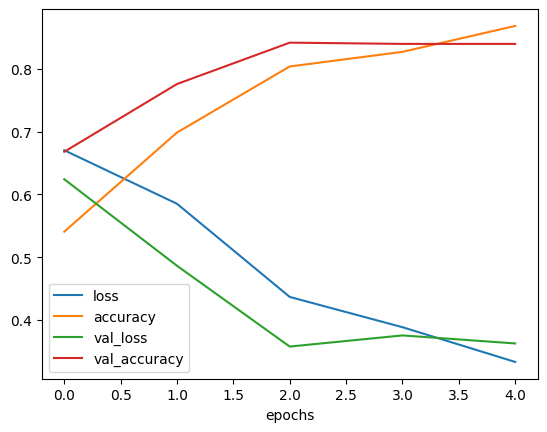

In [12]:
import pandas as pd
pd.DataFrame(history_1.history).plot(xlabel="epochs");

In [13]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 10)      280       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 10)      910       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 10)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 10)      910       
                                                                 
 conv2d_3 (Conv2D)           (None, 106, 106, 10)      910       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 53, 53, 10)       0         
 2D)                                                    

Let's try to fit our earlier model from `learn_tf_003` notebook. The model with 4 layers

In [14]:
# set seed
tf.random.set_seed(42)

# build the model
model_2 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(224,224,3))
    ,tf.keras.layers.Dense(4,activation=tf.keras.activations.relu)
    ,tf.keras.layers.Dense(4,activation=tf.keras.activations.relu)
    ,tf.keras.layers.Dense(1,activation=tf.keras.activations.sigmoid)
])

# compile the model
model_2.compile(loss=tf.keras.losses.binary_crossentropy
                ,optimizer=tf.keras.optimizers.Adam()
                ,metrics=["accuracy"]
                )

# Fit the model
history_2 = model_2.fit(train_data
                        ,steps_per_epoch=len(train_data)
                        ,validation_data=valid_data
                        ,validation_steps=len(valid_data)
                        ,epochs=5)

Epoch 1/5
47/47 [==============================] - 13s 223ms/step - loss: 0.7223 - accuracy: 0.5040 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 2/5
47/47 [==============================] - 10s 215ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 3/5
47/47 [==============================] - 9s 196ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 4/5
47/47 [==============================] - 10s 220ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 5/5
47/47 [==============================] - 10s 217ms/step - loss: 0.6932 - accuracy: 0.4813 - val_loss: 0.6931 - val_accuracy: 0.5000


<Axes: xlabel='epochs'>

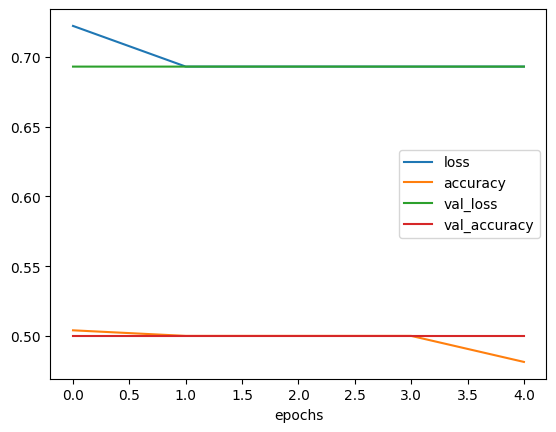

In [15]:
pd.DataFrame(history_2.history).plot(xlabel="epochs")

In [16]:
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 150528)            0         
                                                                 
 dense_1 (Dense)             (None, 4)                 602116    
                                                                 
 dense_2 (Dense)             (None, 4)                 20        
                                                                 
 dense_3 (Dense)             (None, 1)                 5         
                                                                 
Total params: 602,141
Trainable params: 602,141
Non-trainable params: 0
_________________________________________________________________


The last model didn't work . Let's add one more layer and increase the number of neurons( also known as hidden units ) in each dense layer from 4 to 100.

In [17]:
# set random seed
tf.random.set_seed(42)

# build the model
model_3 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(224,224,3))
    ,tf.keras.layers.Dense(100, activation=tf.keras.activations.relu)
    ,tf.keras.layers.Dense(100, activation=tf.keras.activations.relu)
    ,tf.keras.layers.Dense(100, activation=tf.keras.activations.relu)
    ,tf.keras.layers.Dense(1, activation=tf.keras.activations.sigmoid)
])

# compile the model
model_3.compile(loss= tf.keras.losses.binary_crossentropy
                ,optimizer=tf.keras.optimizers.Adam()
                ,metrics=["accuracy"]
                )

# fit the model
history_3 = model_3.fit(train_data
            ,epochs=5
            ,steps_per_epoch=len(train_data)
            ,validation_data=valid_data
            ,validation_steps=len(valid_data)
            )

Epoch 1/5
47/47 [==============================] - 13s 244ms/step - loss: 2.4666 - accuracy: 0.6140 - val_loss: 1.3955 - val_accuracy: 0.6400
Epoch 2/5
47/47 [==============================] - 10s 219ms/step - loss: 0.6844 - accuracy: 0.7280 - val_loss: 0.5069 - val_accuracy: 0.7580
Epoch 3/5
47/47 [==============================] - 12s 259ms/step - loss: 0.6059 - accuracy: 0.7400 - val_loss: 0.4514 - val_accuracy: 0.7880
Epoch 4/5
47/47 [==============================] - 10s 204ms/step - loss: 0.5633 - accuracy: 0.7647 - val_loss: 0.4898 - val_accuracy: 0.7980
Epoch 5/5
47/47 [==============================] - 10s 215ms/step - loss: 0.5937 - accuracy: 0.7507 - val_loss: 0.7034 - val_accuracy: 0.7140


In [18]:
model_3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 150528)            0         
                                                                 
 dense_4 (Dense)             (None, 100)               15052900  
                                                                 
 dense_5 (Dense)             (None, 100)               10100     
                                                                 
 dense_6 (Dense)             (None, 100)               10100     
                                                                 
 dense_7 (Dense)             (None, 1)                 101       
                                                                 
Total params: 15,073,201
Trainable params: 15,073,201
Non-trainable params: 0
_________________________________________________________________


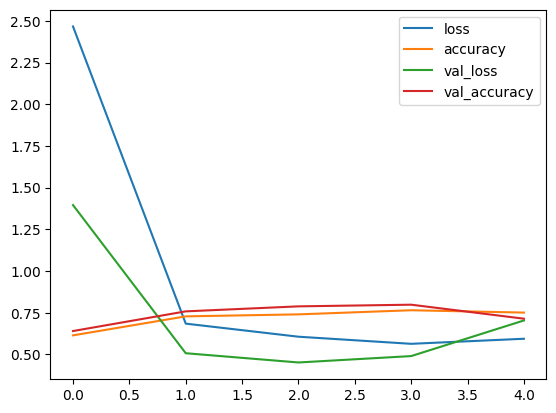

In [19]:
pd.DataFrame(history_3.history).plot();

# Binary Classification

## Step 1 : Be one with Data

 Showing image 387697.jpg from pizza_steak/train/pizza
 Shape of the image (512, 382, 3)
 Showing image 644867.jpg from pizza_steak/train/steak
 Shape of the image (512, 512, 3)


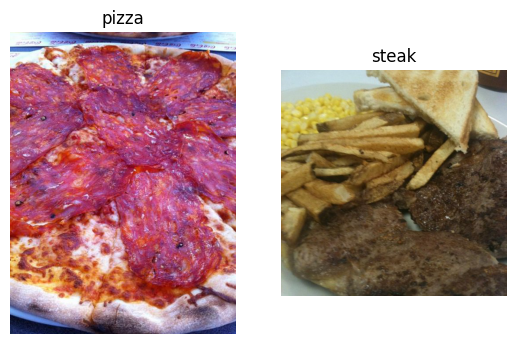

In [20]:
# visualize random images
plt.figure()
plt.subplot(1,2,1)
pizza_img=view_random_image("pizza_steak/train/","pizza")
plt.subplot(1,2,2)
steak_img=view_random_image("pizza_steak/train/","steak")

## Step 2 : Preprocess the data
1. Create the train and test directory paths
2. Create batch: Usually a batch size of 32 works in almost all cases.


In [21]:
#1. Define the train and test directory paths
train_dir = "pizza_steak/train"
test_dir = "pizza_steak/test"


In [22]:
#2. Create Batch:
# To create batch first we need to create an instance of ImageDataGenerator for each dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load images from their respective folders using `.flow_from_directory` method of ImageDataGenerator
train_data = train_datagen.flow_from_directory(directory=train_dir
                                                    ,target_size=(224,224)
                                                    ,class_mode="binary"
                                                    ,batch_size=32)
test_data = test_datagen.flow_from_directory(directory=test_dir
                                                   ,target_size=(224,224)
                                                   ,class_mode="binary"
                                                   ,batch_size=32)

Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


In [23]:
# ImageDataGenerator is deprecated. Let's give a try of following the suggestion of using tf.keras.utils.image_dataset_from_directory` and transforming the output
# `tf.data.Dataset` with preprocessing layers
train_dataset = tf.keras.utils.image_dataset_from_directory(directory=train_dir
                                                            ,image_size=(224,224)
                                                            ,batch_size=32
                                                            ,labels="inferred"
                                                            ,label_mode="binary")

test_dataset = tf.keras.utils.image_dataset_from_directory(directory=test_dir
                                                           ,image_size=(224,224)
                                                           ,batch_size=32
                                                           ,labels="inferred"
                                                           ,label_mode="binary")

Found 1500 files belonging to 2 classes.
Found 500 files belonging to 2 classes.


In [24]:
images,labels = train_data.next()
len(images), len(labels)

(32, 32)

## Step 3 : Build the model

In [25]:
# set seeds
tf.random.set_seed(42)

# build the model
model_4 =  tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=10
                           ,kernel_size=3
                           ,strides=1
                           ,padding="valid"
                           ,activation="relu"
                           ,input_shape=(224,224,3))
    ,tf.keras.layers.Conv2D(10,3,activation="relu")
    ,tf.keras.layers.Conv2D(10,3,activation="relu")
    ,tf.keras.layers.Flatten()
    ,tf.keras.layers.Dense(1,activation="sigmoid")
])

# compile the model
model_4.compile(loss=tf.keras.losses.binary_crossentropy
                ,optimizer=tf.keras.optimizers.Adam()
                ,metrics=["accuracy"]
                )

# fit the model
history_4 = model_4.fit(train_data
            ,steps_per_epoch=len(train_data)
            ,validation_data=test_data
            ,validation_steps=len(test_data)
            ,epochs=5)

Epoch 1/5
47/47 [==============================] - 14s 251ms/step - loss: 1.2247 - accuracy: 0.5467 - val_loss: 0.6342 - val_accuracy: 0.6640
Epoch 2/5
47/47 [==============================] - 11s 236ms/step - loss: 0.5739 - accuracy: 0.7300 - val_loss: 0.4638 - val_accuracy: 0.7920
Epoch 3/5
47/47 [==============================] - 11s 236ms/step - loss: 0.4601 - accuracy: 0.7820 - val_loss: 0.4291 - val_accuracy: 0.8120
Epoch 4/5
47/47 [==============================] - 13s 272ms/step - loss: 0.3713 - accuracy: 0.8520 - val_loss: 0.3753 - val_accuracy: 0.8380
Epoch 5/5
47/47 [==============================] - 12s 251ms/step - loss: 0.2646 - accuracy: 0.8980 - val_loss: 0.3389 - val_accuracy: 0.8580


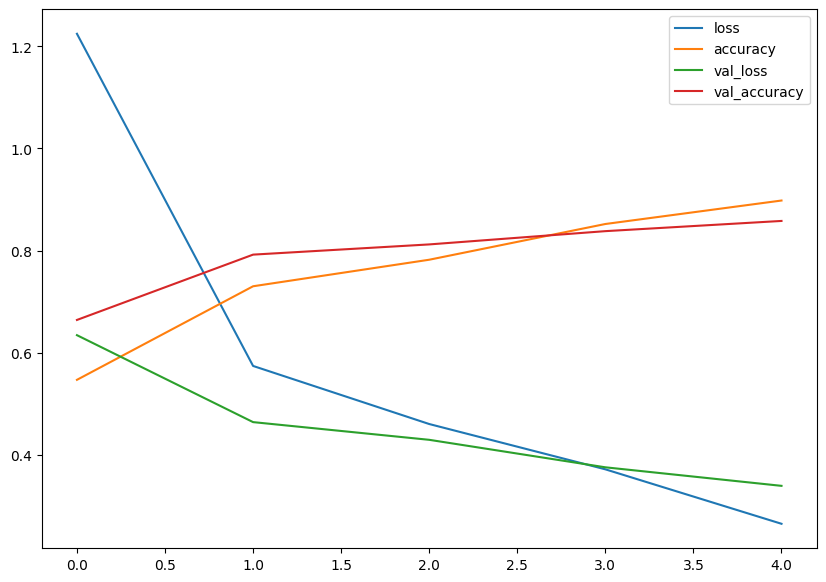

In [26]:
# Plot the loss curve
pd.DataFrame(history_4.history).plot(figsize=(10,7));

In [27]:
print(tf.__version__)

2.12.0


🇹 The current code is using `ImageDataGenerator` to create data for training and validation. We should change it to `tf.keras.utils.image_dataset_from_directory` as suggested in API docs.

Function to separate the loss and accuracy curve.

In [28]:
def plot_loss_curve(history):
  """
    Returns separate loss curves for training and validation metrics
  """

  loss = history["loss"]
  val_loss = history["val_loss"]

  acc=history["accuracy"]
  val_acc = history["val_accuracy"]

  epochs = range(len(history["loss"]))

  # Plot loss
  plt.figure()
  plt.plot(epochs,loss,label="loss")
  plt.plot(epochs,val_loss,label="val_loss")
  plt.title("loss")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs,acc,label="accuracy")
  plt.plot(epochs,val_acc,label="val_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()

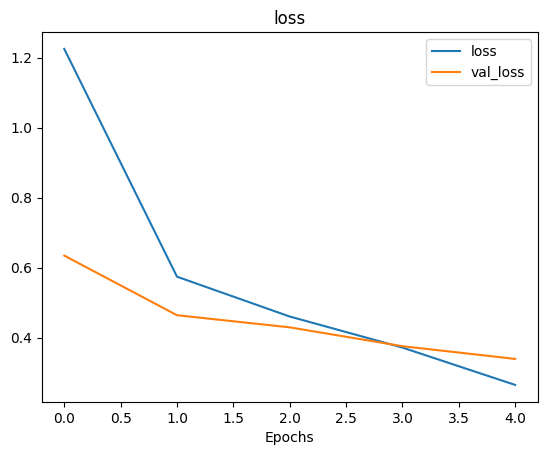

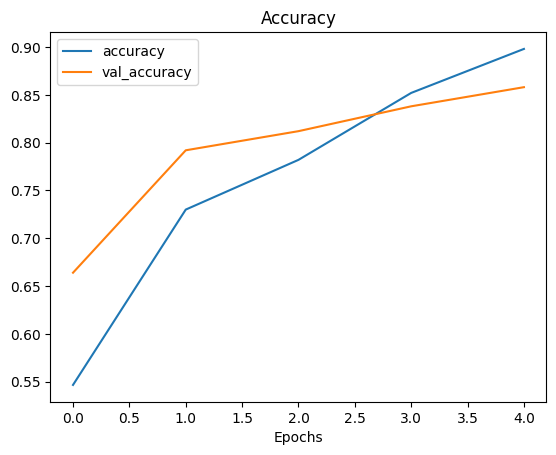

In [29]:
plot_loss_curve(history_4.history)

In [30]:
model_4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 222, 222, 10)      280       
                                                                 
 conv2d_5 (Conv2D)           (None, 220, 220, 10)      910       
                                                                 
 conv2d_6 (Conv2D)           (None, 218, 218, 10)      910       
                                                                 
 flatten_3 (Flatten)         (None, 475240)            0         
                                                                 
 dense_8 (Dense)             (None, 1)                 475241    
                                                                 
Total params: 477,341
Trainable params: 477,341
Non-trainable params: 0
_________________________________________________________________


Let's build 2 more models

* A convnet with [max pooling](https://deeplizard.com/learn/video/ZjM_XQa5s6s)
* A convnet with max pooling and data augmentation

In [31]:
from keras.layers import MaxPool2D
from tensorflow.python.ops.gen_nn_ops import MaxPool
from keras.layers.convolutional.conv2d_transpose import Conv2D
# A model with max pooling

#set seed
tf.random.set_seed(42)

# build the model

model_5 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=10
                           ,kernel_size=3
                           ,padding="valid"
                           ,strides=1
                           ,activation="relu"
                           ,input_shape=(224,224,3))
    ,tf.keras.layers.MaxPool2D(pool_size=2)
    ,Conv2D(10,3,activation="relu")
    ,MaxPool2D()
    ,Conv2D(10,3,activation="relu")
    ,MaxPool2D()
    ,tf.keras.layers.Flatten()
    ,tf.keras.layers.Dense(1,activation="sigmoid")
])

# compile the model

model_5.compile(loss=tf.keras.losses.binary_crossentropy
                ,optimizer=tf.keras.optimizers.Adam()
                ,metrics=["accuracy"]
                )

# fit the model
history_5 = model_5.fit(train_data
                        ,steps_per_epoch=len(train_data)
                        ,validation_data=valid_data
                        ,validation_steps=len(valid_data)
                        ,epochs=5)



Epoch 1/5
47/47 [==============================] - 13s 210ms/step - loss: 0.6026 - accuracy: 0.6780 - val_loss: 0.4197 - val_accuracy: 0.8220
Epoch 2/5
47/47 [==============================] - 11s 226ms/step - loss: 0.4428 - accuracy: 0.8053 - val_loss: 0.3751 - val_accuracy: 0.8420
Epoch 3/5
47/47 [==============================] - 10s 222ms/step - loss: 0.4165 - accuracy: 0.8140 - val_loss: 0.3651 - val_accuracy: 0.8260
Epoch 4/5
47/47 [==============================] - 10s 223ms/step - loss: 0.3976 - accuracy: 0.8227 - val_loss: 0.3811 - val_accuracy: 0.8320
Epoch 5/5
47/47 [==============================] - 9s 201ms/step - loss: 0.4047 - accuracy: 0.8153 - val_loss: 0.3525 - val_accuracy: 0.8720


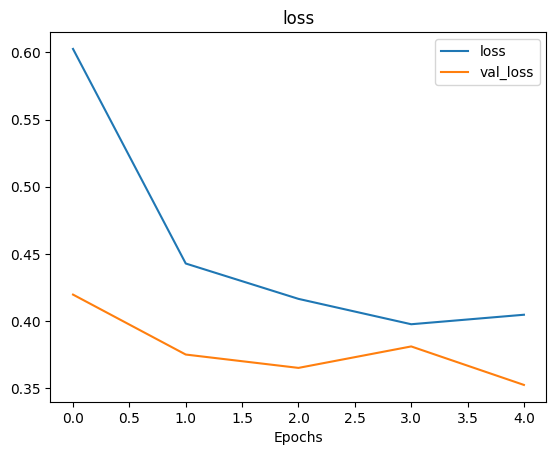

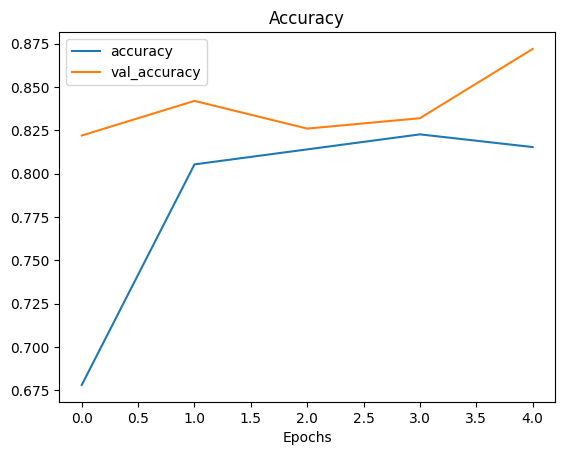

In [32]:
plot_loss_curve(history_5.history)

In [33]:
model_5.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 222, 222, 10)      280       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 111, 111, 10)     0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 109, 109, 10)      910       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 54, 54, 10)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 52, 52, 10)        910       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 26, 26, 10)      

#### Perform Data augmentation

In [34]:
# Create ImageDataGenerator instance with data augmentation
train_datagen_augmented = ImageDataGenerator(rescale=1./255
                                          ,rotation_range=20
                                          ,shear_range=0.2
                                          ,zoom_range=0.2
                                          ,width_shift_range=0.2
                                          ,height_shift_range=0.2
                                          ,horizontal_flip=True)

# Create ImageDataGenerator instance without data augmentation
train_datagen = ImageDataGenerator(rescale=1./255)

# Create ImageDataGenerator instance without data augmentation
test_datagen = ImageDataGenerator(rescale=1./255)

In [35]:
print(f"Augmented training data")
train_data_augmented = train_datagen_augmented.flow_from_directory(train_dir
                                                                ,target_size=(224,224)
                                                                ,batch_size=32
                                                                ,class_mode="binary"
                                                                ,shuffle=False)

print(f"Non-Augmented training data")
train_data = train_datagen.flow_from_directory(train_dir
                                               ,target_size=(224,224)
                                               ,batch_size=32
                                               ,class_mode="binary"
                                               ,shuffle=False)

print(f"Non-Augmented test data")
test_data = test_datagen.flow_from_directory(test_dir
                                             ,target_size=(224,224)
                                             ,batch_size=32
                                             ,class_mode="binary"
                                            )

Augmented training data
Found 1500 images belonging to 2 classes.
Non-Augmented training data
Found 1500 images belonging to 2 classes.
Non-Augmented test data
Found 500 images belonging to 2 classes.


In [36]:
images,labels= train_data.next()
augmented_images,augmented_labels=train_data_augmented.next()

 Random number : 2


(-0.5, 223.5, 223.5, -0.5)

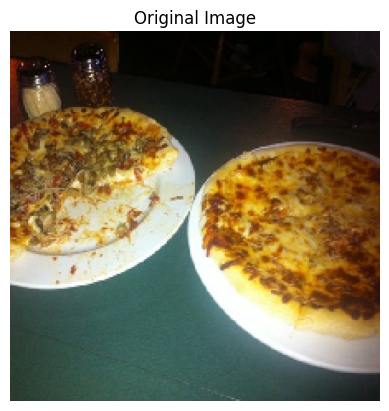

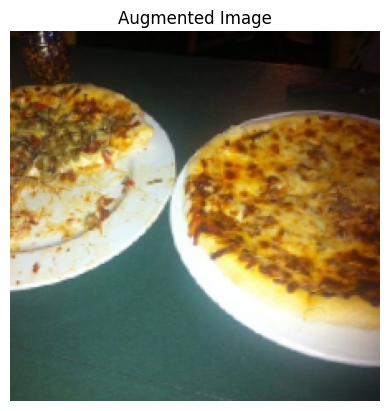

In [37]:
#show a random image
random_number = random.randint(0,32)
print(f" Random number : {random_number}")
plt.imshow(images[random_number])
plt.title(f"Original Image")
plt.axis(False)
plt.figure()
plt.imshow(augmented_images[random_number])
plt.title(f"Augmented Image")
plt.axis(False)

In [38]:
# set seeds
tf.random.set_seed(42)

# build the model
model_6 = tf.keras.Sequential([
    Conv2D(10,3,activation="relu",input_shape=(224,224,3))
    ,MaxPool2D(pool_size=2)
    ,Conv2D(10,3,activation="relu")
    ,MaxPool2D()
    ,Conv2D(10,3,activation="relu")
    ,MaxPool2D()
    ,tf.keras.layers.Flatten()
    ,tf.keras.layers.Dense(1,activation="sigmoid")
])

# compile the model
model_6.compile(loss=tf.keras.losses.binary_crossentropy
                ,optimizer=tf.keras.optimizers.Adam()
                ,metrics=["accuracy"]
                )

# fit the model
history_6 = model_6.fit(train_data_augmented
            ,steps_per_epoch=len(train_data_augmented)
            ,validation_data=test_data
            ,validation_steps=len(test_data)
            ,epochs=5)


Epoch 1/5
47/47 [==============================] - 26s 526ms/step - loss: 0.7092 - accuracy: 0.5507 - val_loss: 0.6915 - val_accuracy: 0.5000
Epoch 2/5
47/47 [==============================] - 26s 549ms/step - loss: 0.7061 - accuracy: 0.4213 - val_loss: 0.6856 - val_accuracy: 0.5020
Epoch 3/5
47/47 [==============================] - 25s 524ms/step - loss: 0.6879 - accuracy: 0.5067 - val_loss: 0.6628 - val_accuracy: 0.7980
Epoch 4/5
47/47 [==============================] - 25s 524ms/step - loss: 0.7126 - accuracy: 0.6713 - val_loss: 0.6425 - val_accuracy: 0.6580
Epoch 5/5
47/47 [==============================] - 24s 501ms/step - loss: 0.7096 - accuracy: 0.5847 - val_loss: 0.6708 - val_accuracy: 0.5160


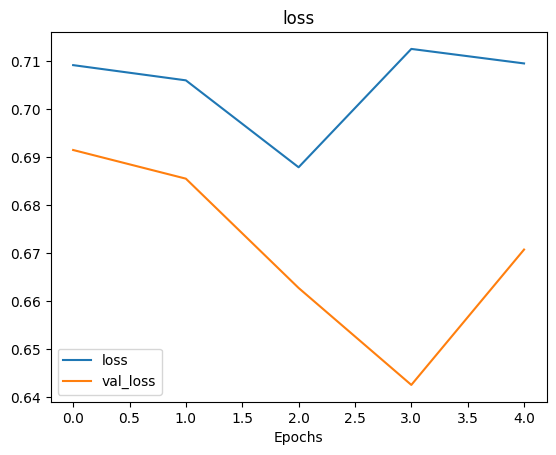

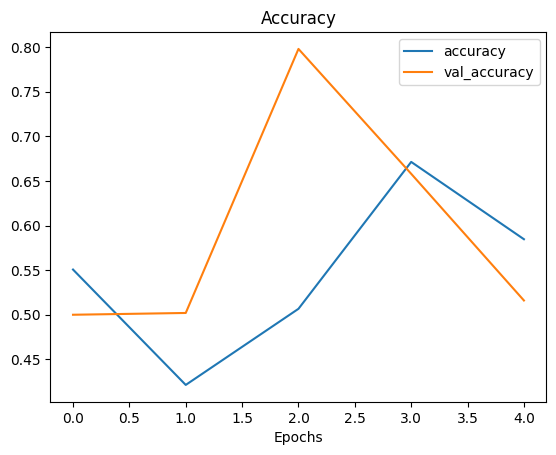

In [39]:
plot_loss_curve(history_6.history)

🤔 Why didn't the model get very good results on the training set to begin with ❔

It's because when we created `train_data_augmented`, we didn't disabled shuffle using `shuffle=False` which means our model only sees a batch of single kind of images at a time.

For example, the pizza class gets loaded first because it's the first class.Thus it's performance is measured on only a single class rather than both classes.The validation data performance improves steadily becuase it contains shuffled data.

The `ImageDataGenerator` augments the data as it's loaded to the model. The _benefit_ is that it leaves the original image unchanged but the _downside_ of the approach is that it takes longer to load the images.

The above is behaviour can be observed from the increase in time for each epoch from ~13sec to ~26sec

Let's now shuffle the augmented data and check the model performance on training and validation data.

In [40]:
train_data_augmented_shuffled = train_datagen_augmented.flow_from_directory(train_dir
                                                                            ,class_mode="binary"
                                                                            ,target_size=(224,224)
                                                                            ,batch_size=32
                                                                            ,shuffle=True)

Found 1500 images belonging to 2 classes.


In [41]:
# build the model

# set seeds
tf.random.set_seed(42)

# build the model
model_7 = tf.keras.Sequential([
    Conv2D(10,3,activation="relu",input_shape=(224,224,3))
    ,MaxPool2D(pool_size=2)
    ,Conv2D(10,3,activation="relu")
    ,MaxPool2D()
    ,Conv2D(10,3,activation="relu")
    ,MaxPool2D()
    ,tf.keras.layers.Flatten()
    ,tf.keras.layers.Dense(1,activation="sigmoid")
])

# compile the model
model_7.compile(loss=tf.keras.losses.binary_crossentropy
              ,optimizer=tf.keras.optimizers.Adam()
              ,metrics=["accuracy"]
              )

# fit the model
history_7 = model_7.fit(train_data_augmented_shuffled
                        ,steps_per_epoch=len(train_data_augmented_shuffled)
                        ,validation_data=test_data
                        ,validation_steps=len(test_data)
                        ,epochs=5)

Epoch 1/5
47/47 [==============================] - 26s 516ms/step - loss: 0.6555 - accuracy: 0.6047 - val_loss: 0.5699 - val_accuracy: 0.6840
Epoch 2/5
47/47 [==============================] - 25s 542ms/step - loss: 0.5904 - accuracy: 0.6973 - val_loss: 0.4756 - val_accuracy: 0.7840
Epoch 3/5
47/47 [==============================] - 24s 522ms/step - loss: 0.5316 - accuracy: 0.7527 - val_loss: 0.4046 - val_accuracy: 0.8200
Epoch 4/5
47/47 [==============================] - 25s 531ms/step - loss: 0.4920 - accuracy: 0.7573 - val_loss: 0.3757 - val_accuracy: 0.8380
Epoch 5/5
47/47 [==============================] - 25s 525ms/step - loss: 0.4718 - accuracy: 0.7840 - val_loss: 0.3570 - val_accuracy: 0.8480


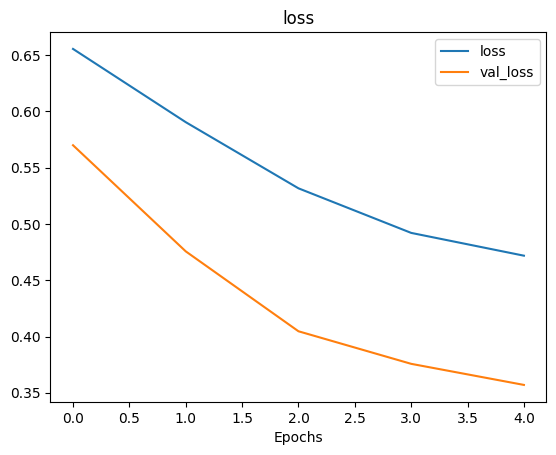

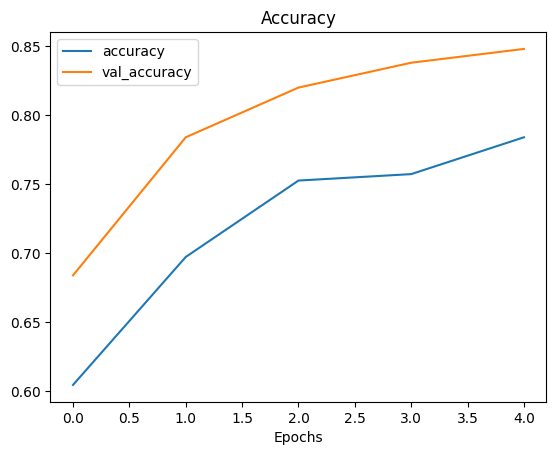

In [42]:
plot_loss_curve(history_7.history)

Make a prediction using the trained model

In [43]:
print(classnames)

['pizza', 'steak']


--2023-07-08 03:14:33--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-steak.jpeg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1978213 (1.9M) [image/jpeg]
Saving to: ‘03-steak.jpeg.1’

03-steak.jpeg.1     100%[===================>]   1.89M  --.-KB/s    in 0.02s   

2023-07-08 03:14:34 (84.6 MB/s) - ‘03-steak.jpeg.1’ saved [1978213/1978213]



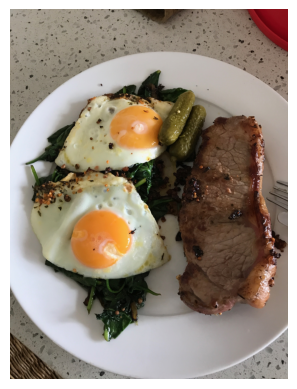

In [44]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-steak.jpeg
steak = mpimg.imread("03-steak.jpeg")
plt.imshow(steak)
plt.axis(False);

In [45]:
steak.shape

(4032, 3024, 3)

Our model is trained for image size = (224,224), so we have to resize the steak image to make it suitable for our model.
For this we will have to use `tf.io.read_file` (for reading files) and `tf.image` (for resizing our image and turning it into tensor)

In [46]:
def load_and_prep_image(filename,img_shape=224):
  """
    Reads an image from filename, turn it into tensor
    and reshape it to (img_shape, img_shape, color_channel)
  """

  # Read in target file ( an image )
  img = tf.io.read_file(filename)

  # Decode the read file into a tensor & ensure 3 color channels
  img = tf.image.decode_image(img,channels=3)

  # Resize the image
  img = tf.image.resize(img,size=[img_shape,img_shape])

  # Rescale the image
  return img/255.

In [47]:
img_tensor = load_and_prep_image("/content/03-steak.jpeg")
img_tensor.shape

TensorShape([224, 224, 3])

In [48]:
pred_probs = model_7.predict(tf.expand_dims(img_tensor,axis=0))

1/1 [==============================] - 0s 184ms/step


In [49]:
tf.expand_dims(img_tensor,axis=0).shape

TensorShape([1, 224, 224, 3])

In [50]:
predicted_class = classnames[int(tf.round(pred_probs)[0][0])]
predicted_class

'steak'

# Multi-class classification

Steps Involved
1. Become one with data ( visualize, visualize, visualize )
2. Preprocess the data ( prepare it for model )
3. Create a model ( start with baseline )
4. Fit a model
5. Evaluate the model
6. Adjust different parameters and improve the model.
7. Repeat until satisfied.

In [51]:
import zipfile

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip

#unzip the download file
zip_ref = zipfile.ZipFile("/content/10_food_classes_all_data.zip")
zip_ref.extractall()
zip_ref.close()

--2023-07-08 03:14:37--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.31.128, 142.250.153.128, 142.250.145.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.31.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip.1’

10_food_classes_all 100%[===================>] 495.13M  40.3MB/s    in 14s     

2023-07-08 03:14:51 (36.7 MB/s) - ‘10_food_classes_all_data.zip.1’ saved [519183241/519183241]



In [52]:
!rm -r /content/__MACOSX

## Be one with data

In [53]:
import os

for dirpath,dirnames,filesnames in os.walk("/content/10_food_classes_all_data"):
  print(f"There are {len(dirnames)} and {len(filenames)} images in {dirpath}")

There are 2 and 250 images in /content/10_food_classes_all_data
There are 10 and 250 images in /content/10_food_classes_all_data/train
There are 0 and 250 images in /content/10_food_classes_all_data/train/ramen
There are 0 and 250 images in /content/10_food_classes_all_data/train/chicken_wings
There are 0 and 250 images in /content/10_food_classes_all_data/train/pizza
There are 0 and 250 images in /content/10_food_classes_all_data/train/grilled_salmon
There are 0 and 250 images in /content/10_food_classes_all_data/train/steak
There are 0 and 250 images in /content/10_food_classes_all_data/train/chicken_curry
There are 0 and 250 images in /content/10_food_classes_all_data/train/ice_cream
There are 0 and 250 images in /content/10_food_classes_all_data/train/sushi
There are 0 and 250 images in /content/10_food_classes_all_data/train/hamburger
There are 0 and 250 images in /content/10_food_classes_all_data/train/fried_rice
There are 10 and 250 images in /content/10_food_classes_all_data/te

In [54]:
train_dir = "10_food_classes_all_data/train/"
test_dir = "10_food_classes_all_data/test/"

classnames_10 = get_classnames(train_dir=train_dir)
classnames_10

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

 Showing image 612548.jpg from 10_food_classes_all_data/train/ice_cream
 Shape of the image (512, 512, 3)


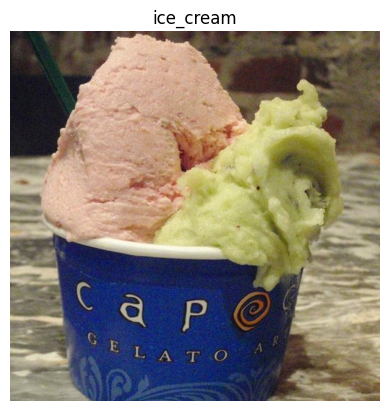

In [55]:
import random
icecream = view_random_image(target_dir=train_dir,target_class="ice_cream")

 Showing image 31881.jpg from 10_food_classes_all_data/train/steak
 Shape of the image (512, 384, 3)


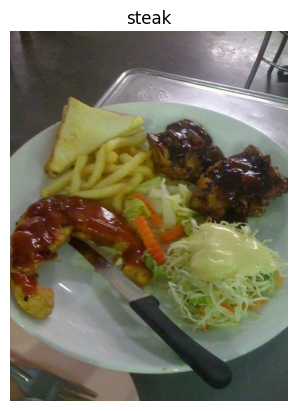

In [56]:
random_train_img = view_random_image(target_dir=train_dir,target_class=random.choice(classnames_10))

 Showing image 3517335.jpg from 10_food_classes_all_data/test/chicken_wings
 Shape of the image (512, 384, 3)


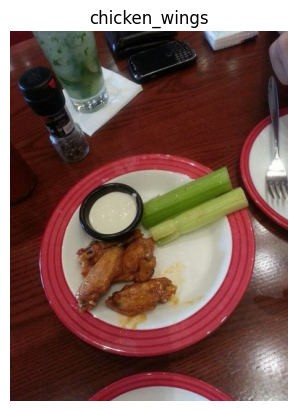

In [57]:
random_test_img = view_random_image(target_dir=test_dir,target_class=random.choice(classnames_10))

## Pre-Process the data

In [58]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(train_dir
                                               ,class_mode="categorical"
                                               ,batch_size=32
                                               ,target_size=(224,224)
                                               )

test_data = test_datagen.flow_from_directory(test_dir
                                             ,class_mode="categorical"
                                             ,batch_size=32
                                             ,target_size=(224,224)
                                             )


Found 7500 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


## Create a Baseline model

We can use the same model (TinyVGG) we used for the binary classification problem for our multi-class classification problem with a couple of small tweaks.

1. Change the output layers to 10 output neurons
2. Change the output layer to use `softmax` instead of `sigmoid`
3. Change the loss function from `binary_crossentropy` to `categorical_crossentropy`

In [59]:
# set seeds
tf.random.set_seed(42)

# build the model
model_8 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=10
                           ,kernel_size=3
                           ,padding="valid"
                           ,strides=1
                           ,activation="relu"
                           ,input_shape=(224,224,3)
                           )
    ,tf.keras.layers.MaxPool2D(pool_size=2)
    ,Conv2D(10,3,activation="relu")
    ,MaxPool2D()
    ,Conv2D(10,3,activation="relu")
    ,MaxPool2D()
    ,tf.keras.layers.Flatten()
    ,tf.keras.layers.Dense(10,activation=tf.keras.activations.softmax)
])

# compile the model
model_8.compile(loss=tf.keras.losses.categorical_crossentropy
                ,optimizer=tf.keras.optimizers.Adam()
                ,metrics=["accuracy"]
                )

# Fit the model
history_8 = model_8.fit(train_data
                        ,steps_per_epoch=len(train_data)
                        ,validation_data=test_data
                        ,validation_steps=len(test_data)
                        ,epochs=5
                        )

Epoch 1/5
235/235 [==============================] - 52s 215ms/step - loss: 2.1295 - accuracy: 0.2265 - val_loss: 1.9755 - val_accuracy: 0.3004
Epoch 2/5
235/235 [==============================] - 50s 213ms/step - loss: 1.9015 - accuracy: 0.3347 - val_loss: 1.8701 - val_accuracy: 0.3416
Epoch 3/5
235/235 [==============================] - 51s 217ms/step - loss: 1.7569 - accuracy: 0.4037 - val_loss: 1.8526 - val_accuracy: 0.3544
Epoch 4/5
235/235 [==============================] - 50s 212ms/step - loss: 1.5857 - accuracy: 0.4669 - val_loss: 1.8556 - val_accuracy: 0.3556
Epoch 5/5
235/235 [==============================] - 60s 255ms/step - loss: 1.3913 - accuracy: 0.5325 - val_loss: 1.9422 - val_accuracy: 0.3500


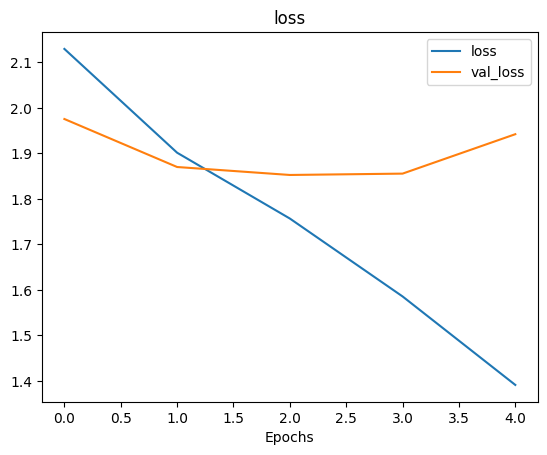

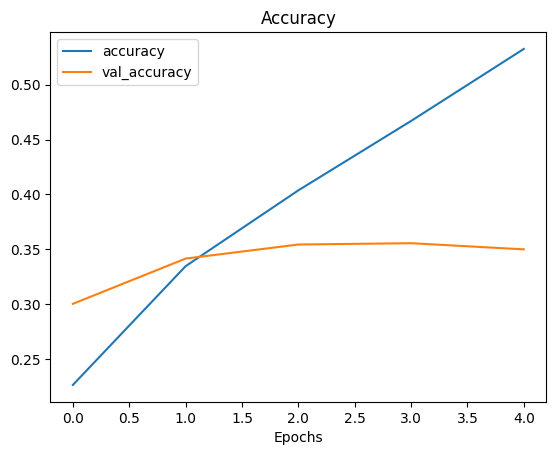

In [60]:
plot_loss_curve(history_8.history)

Looking at the curve , it seems the model is **overfitting** the training set quite badly.In other words, it's getting great results on the training data but fails to generalize well to unseen data and performs poorly on unseen data.

### Ways to improve the model
* Get more data
* Simplify the model
* Use data augmentation
* Use transfer learning

🔑note: Preventing overfitting is also referred to as regularization

Let's try with **data augmentation** as first attempt to prevent our model from overfitting. Data Augmentation makes it harder for the model to learn on the training data and in turn, hopefully will make patterns it learns more generic in order to perform on generalized data.

In [61]:
# Create augmented data
train_datagen_augmented = ImageDataGenerator(rescale=1/255.
                                             ,rotation_range=20
                                             ,width_shift_range=0.2
                                             ,height_shift_range=0.2
                                             ,zoom_range=0.2
                                             ,horizontal_flip=True)

train_data_augmented = train_datagen_augmented.flow_from_directory(train_dir
                                                                   ,target_size=(224,224)
                                                                   ,class_mode="categorical"
                                                                   ,batch_size=32
                                                                   ,shuffle=True)


Found 7500 images belonging to 10 classes.


In [62]:
# Re-use the model architecture
model_9 = tf.keras.models.clone_model(model_8)

# Compile the model
model_9.compile(loss=tf.keras.losses.categorical_crossentropy
                ,optimizer=tf.keras.optimizers.Adam()
                ,metrics=["accuracy"]
                )

# fit the model
history_9 = model_9.fit(train_data_augmented
                        ,steps_per_epoch=len(train_data_augmented)
                        ,validation_data=test_data
                        ,validation_steps=len(test_data)
                        ,epochs=5)

Epoch 1/5
235/235 [==============================] - 125s 520ms/step - loss: 2.1991 - accuracy: 0.1859 - val_loss: 2.0358 - val_accuracy: 0.2504
Epoch 2/5
235/235 [==============================] - 124s 527ms/step - loss: 2.0682 - accuracy: 0.2640 - val_loss: 1.9394 - val_accuracy: 0.2944
Epoch 3/5
235/235 [==============================] - 124s 527ms/step - loss: 2.0398 - accuracy: 0.2772 - val_loss: 1.8774 - val_accuracy: 0.3300
Epoch 4/5
235/235 [==============================] - 130s 553ms/step - loss: 1.9949 - accuracy: 0.2988 - val_loss: 1.8152 - val_accuracy: 0.3544
Epoch 5/5
235/235 [==============================] - 122s 519ms/step - loss: 1.9563 - accuracy: 0.3203 - val_loss: 1.9708 - val_accuracy: 0.3160


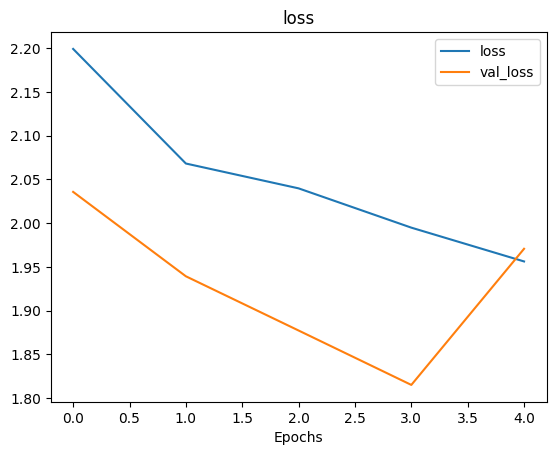

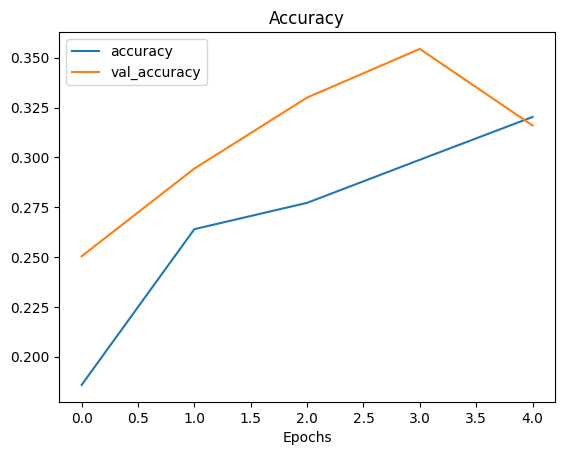

In [63]:
plot_loss_curve(history_9.history)

In [64]:
train_dir,test_dir

('10_food_classes_all_data/train/', '10_food_classes_all_data/test/')

In [67]:

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir
                                                            ,labels="inferred"
                                                            ,label_mode="categorical"
                                                            ,image_size=(224,224)
                                                            ,shuffle=True
                                                            ,batch_size=32)
test_dataset = tf.keras.utils.image_dataset_from_directory(test_dir
                                                           ,labels="inferred"
                                                           ,label_mode="categorical"
                                                           ,image_size=(224,224)
                                                           ,shuffle=True
                                                           ,batch_size=32)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [68]:
model_10 = tf.keras.models.clone_model(model_8)

# compile
model_10.compile(loss=tf.keras.losses.categorical_crossentropy
                 ,optimizer=tf.keras.optimizers.Adam()
                 ,metrics=["accuracy"]
                 )

# fit the model
history_10 = model_10.fit(train_dataset
                          ,steps_per_epoch=len(train_dataset)
                          ,validation_data=test_dataset
                          ,validation_steps=len(test_dataset)
                          ,epochs=5
                          )

Epoch 1/5
235/235 [==============================] - 24s 92ms/step - loss: 4.3332 - accuracy: 0.1031 - val_loss: 2.3068 - val_accuracy: 0.1060
Epoch 2/5
235/235 [==============================] - 24s 100ms/step - loss: 2.2953 - accuracy: 0.1127 - val_loss: 2.3074 - val_accuracy: 0.1092
Epoch 3/5
235/235 [==============================] - 25s 106ms/step - loss: 2.2642 - accuracy: 0.1335 - val_loss: 2.3267 - val_accuracy: 0.1156
Epoch 4/5
235/235 [==============================] - 28s 116ms/step - loss: 2.1789 - accuracy: 0.1916 - val_loss: 2.3612 - val_accuracy: 0.1164
Epoch 5/5
235/235 [==============================] - 22s 90ms/step - loss: 2.0247 - accuracy: 0.2635 - val_loss: 2.5198 - val_accuracy: 0.1360


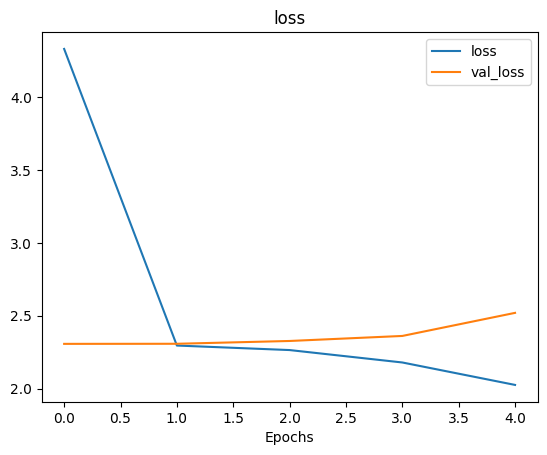

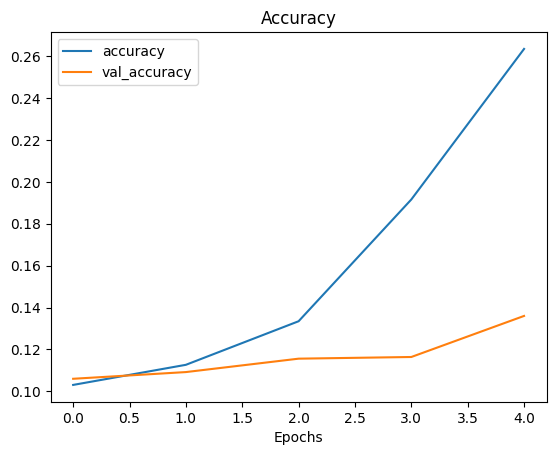

In [69]:
plot_loss_curve(history_10.history)

In [70]:
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [75]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential


model_11 = Sequential([
    layers.Rescaling(scale=1./255,input_shape=(224,224,3))
    ,layers.Conv2D(10,3,activation="relu")
    ,layers.MaxPool2D(pool_size=2)
    ,layers.Conv2D(10,3,activation="relu")
    ,layers.MaxPool2D()
    ,layers.Conv2D(10,3,activation="relu")
    ,layers.MaxPool2D()
    ,layers.Flatten()
    ,layers.Dense(10,activation="softmax")
])
# compile the model
model_11.compile(loss=tf.keras.losses.categorical_crossentropy
                 ,optimizer=tf.keras.optimizers.Adam()
                 ,metrics=["accuracy"]
                 )

# fit the model
history_11 = model_11.fit(train_dataset
              ,steps_per_epoch=len(train_dataset)
              ,validation_data=test_dataset
              ,validation_steps=len(test_dataset)
              ,epochs=5
                          )

Epoch 1/5
235/235 [==============================] - 13s 45ms/step - loss: 2.1032 - accuracy: 0.2428 - val_loss: 1.9947 - val_accuracy: 0.2828
Epoch 2/5
235/235 [==============================] - 5s 23ms/step - loss: 1.8694 - accuracy: 0.3519 - val_loss: 1.8982 - val_accuracy: 0.3408
Epoch 3/5
235/235 [==============================] - 5s 23ms/step - loss: 1.7254 - accuracy: 0.4131 - val_loss: 1.8159 - val_accuracy: 0.3640
Epoch 4/5
235/235 [==============================] - 5s 22ms/step - loss: 1.5567 - accuracy: 0.4725 - val_loss: 1.8246 - val_accuracy: 0.3872
Epoch 5/5
235/235 [==============================] - 5s 23ms/step - loss: 1.4252 - accuracy: 0.5243 - val_loss: 1.8888 - val_accuracy: 0.3708


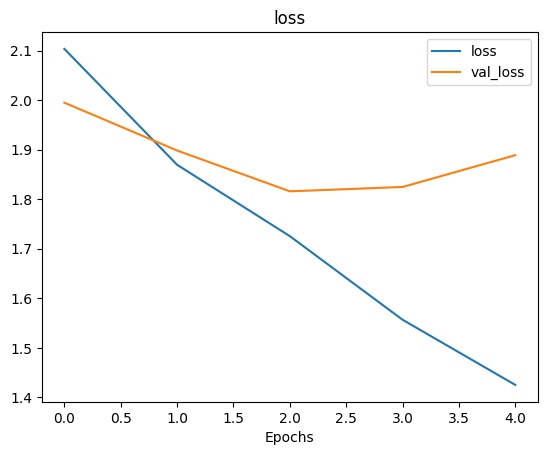

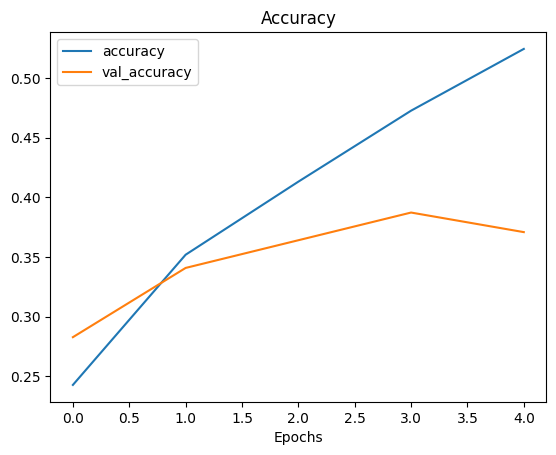

In [76]:
plot_loss_curve(history_11.history)

As evident from loss curve graph the model is overfitting. Let's try data augmentation and retrain the model as **data augmentation** will make it harder for the model to train on training data and hence will be able to learn the pattern in more generic way to perform better on unseen data

In [77]:
data_augmentation = Sequential([
    layers.RandomFlip("horizontal",input_shape=(224,224,3))
    ,layers.RandomRotation(0.1)
    ,layers.RandomZoom(0.1)
])

In [80]:
tf.random.set_seed(42)

model_12 = Sequential([
    data_augmentation
    ,layers.Rescaling(scale=1./255,input_shape=(224,224,3))
    ,layers.Conv2D(10,3,activation="relu")
    ,layers.MaxPool2D(pool_size=2)
    ,layers.Conv2D(10,3,activation="relu")
    ,layers.MaxPool2D()
    ,layers.Conv2D(10,3,activation="relu")
    ,layers.MaxPool2D()
    ,layers.Flatten()
    ,layers.Dense(10,activation="sigmoid")
  ])

model_12.compile(loss= tf.keras.losses.categorical_crossentropy
                 ,optimizer=tf.keras.optimizers.Adam()
                 ,metrics=["accuracy"]
                 )

history_12 = model_12.fit(train_dataset
                          ,steps_per_epoch=len(train_dataset)
                          ,validation_data=test_dataset
                          ,validation_steps=len(test_dataset)
                          ,epochs=5
                          )

Epoch 1/5
235/235 [==============================] - 10s 28ms/step - loss: 2.1844 - accuracy: 0.1891 - val_loss: 2.0404 - val_accuracy: 0.2788
Epoch 2/5
235/235 [==============================] - 6s 25ms/step - loss: 2.0018 - accuracy: 0.2971 - val_loss: 1.9431 - val_accuracy: 0.3136
Epoch 3/5
235/235 [==============================] - 6s 26ms/step - loss: 1.9678 - accuracy: 0.3145 - val_loss: 1.9315 - val_accuracy: 0.3016
Epoch 4/5
235/235 [==============================] - 6s 25ms/step - loss: 1.9252 - accuracy: 0.3268 - val_loss: 1.9000 - val_accuracy: 0.3420
Epoch 5/5
235/235 [==============================] - 6s 25ms/step - loss: 1.8815 - accuracy: 0.3487 - val_loss: 1.8119 - val_accuracy: 0.3756


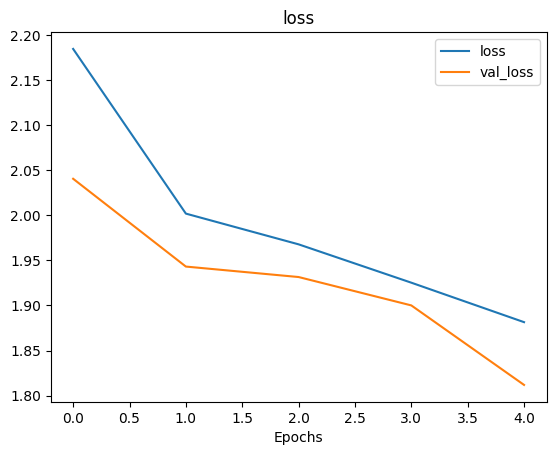

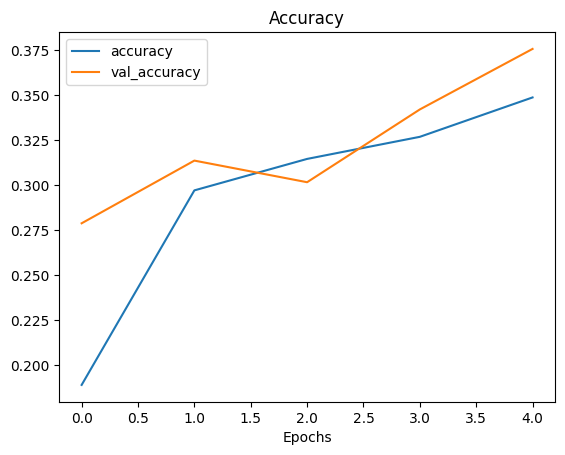

In [81]:
plot_loss_curve(history_12.history)

In [82]:
model_12.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_10 (Sequential)  (None, 224, 224, 3)       0         
                                                                 
 rescaling_4 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_29 (Conv2D)          (None, 222, 222, 10)      280       
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 111, 111, 10)     0         
 g2D)                                                            
                                                                 
 conv2d_30 (Conv2D)          (None, 109, 109, 10)      910       
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 54, 54, 10)       0         
 g2D)                                                

In [97]:
def pred_and_plot(model,filename,class_names):
  """
    Imports an image located at filename, makes a prediction on it with
    a trained model and plots the image with predicted class as the title
  """

  #import the image and preprocess it
  img = load_and_prep_image(filename)

  # Make prediction
  pred = model.predict(tf.expand_dims(img,axis=0))
  print(f" Prediction Prob: {pred}")
  # Get the predicted class
  if len(pred[0]) > 1:
    pred_class = class_names[pred.argmax()]
  else:
    pred_class = class_names[int(tf.round(pred[0][0]))]

  # Plot the image
  plt.imshow(img)
  plt.title(f" Prediction: {pred_class}")
  plt.axis(False);



In [98]:
classnames,classnames_10

(['pizza', 'steak'],
 ['chicken_curry',
  'chicken_wings',
  'fried_rice',
  'grilled_salmon',
  'hamburger',
  'ice_cream',
  'pizza',
  'ramen',
  'steak',
  'sushi'])

1/1 [==============================] - 0s 20ms/step
 Prediction Prob: [[0.04015721 0.11068981 0.00930826 0.11922088 0.28183135 0.49574333
  0.00523826 0.44309607 0.6749058  0.34930003]]


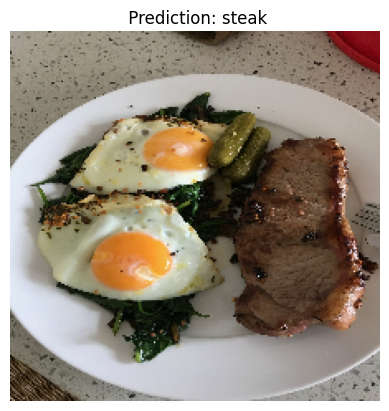

In [99]:
pred_and_plot(model_12,"/content/03-steak.jpeg",classnames_10)

In [93]:
!wget -q https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-hamburger.jpeg

1/1 [==============================] - 0s 21ms/step
 Prediction Prob: [[0.03944587 0.10945216 0.00919627 0.11589961 0.2798517  0.49579385
  0.00522043 0.44425535 0.6735166  0.34967232]]


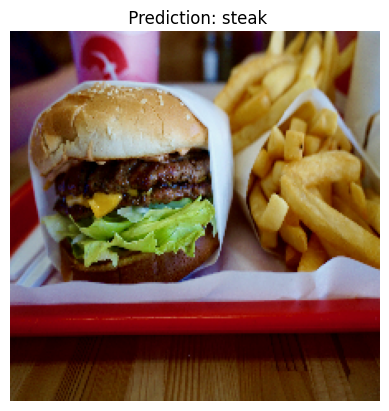

In [100]:
pred_and_plot(model_12,"/content/03-hamburger.jpeg",classnames_10)

1/1 [==============================] - 0s 25ms/step


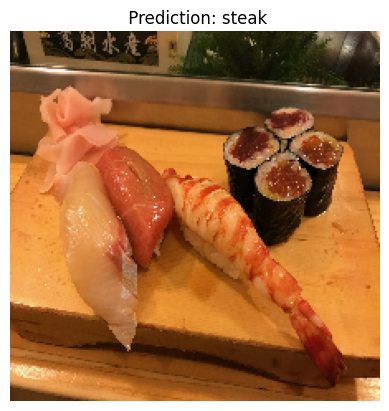

In [96]:
!wget -q https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-sushi.jpeg
pred_and_plot(model_12,"/content/03-sushi.jpeg",classnames_10)

1/1 [==============================] - 0s 22ms/step
 Prediction Prob: [[0.0392044  0.11203956 0.00899538 0.11665928 0.2800232  0.49008542
  0.00511584 0.4403622  0.6764846  0.34390485]]


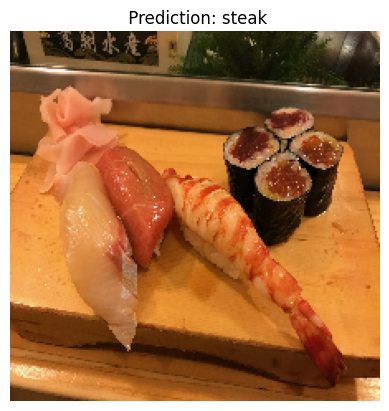

In [101]:
pred_and_plot(model_12,"/content/03-sushi.jpeg",classnames_10)